In [1]:
# import gymnasium as gym
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
# from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time
import matplotlib.animation as animation
from IPython.display import display, HTML
import dosing_rl_gym
# from dosing_rl_gym.util import plot_env
from joblib import Parallel, delayed

In [2]:
# Hyperparameters
learning_rate = 1e-2
value_lr = 5e-3
gamma = 0.9
hidden_size = 64
batch_size = 1500
# sigma = C * 0.0001  # Standard deviation of Gaussian noise
n_obs = 9
n_actions = 2
normalise_factor = [200, 112, 112, 56, 56, 840, 1640, 200, 1640]
env_name = "Diabetic-v1"
n_episodes = 20
norms = []
beta = 0.01  # regulariser for entropy

def normalise(obs):
        for i in range(9):
            obs[i] = obs[i] / normalise_factor[i]
        return obs

def cross_entropy_loss(probs):
    return -torch.sum(probs * torch.log(probs + 1e-8), dim=-1).mean()

def log_barrier_loss(probs):
    log_probs = torch.log(probs + 1e-8)
    return -torch.sum(log_probs, dim=-1).mean()

# Policy Network
class PolicyNet(nn.Module):
    def __init__(self, obs_dim, act_dim):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(obs_dim, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, act_dim),
            nn.Softmax(dim=-1)
        )
    
    def forward(self, obs):
        return self.fc(obs)

# Value Network
class ValueNet(nn.Module):
    def __init__(self, obs_dim):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(obs_dim, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1)
        )
    
    def forward(self, obs):
        return self.fc(obs).squeeze()
    

class Agent:
    def __init__(self, sig=1e-4, beta=0.0, n_episodes=20, n_actions=5, regularizer=cross_entropy_loss, C=350):
        self.sigma = sig * C / n_episodes
        self.policy = PolicyNet(n_obs, n_actions)
        self.value_net = ValueNet(n_obs)
        self.policy_optimizer = optim.Adam(self.policy.parameters(), lr=learning_rate)
        self.value_optimizer = optim.Adam(self.value_net.parameters(), lr=value_lr)
        env_name = "Diabetic-v1"       
        self.env = gym.make(env_name)
        self.env.set_episode_length(10)
        self.beta = beta
        self.action_multiplier = 10/(n_actions-1)
        self.n_episodes = n_episodes
        self.epoch_wise_returns = []
        self.norms = []
        self.regularizer = regularizer
        self.C = C

    def get_action(self, obs):
        obs = torch.tensor(obs, dtype=torch.float32)
        probs = self.policy(obs)
        action = torch.multinomial(probs, num_samples=1).item()
        return action

    def compute_returns(self, rewards, gamma):
        returns = [0] * len(rewards)
        G = 0  # If truncated, use V(s) instead of 0
        for i in reversed(range(len(rewards))):
            G = rewards[i] + gamma * G
            returns[i] = G
        return returns
    
    def compute_extras_cpu(self, batch_last_states, batch_lens):
        # Ensure everything is on CPU
        

        extra_vals = self.value_net(batch_last_states)  # shape: (n_episodes,)
        
        # Compute multiplicative powers of gamma
        repeated_lengths = batch_lens
        total_length = repeated_lengths.sum()
        powers = torch.cat([gamma ** torch.arange(length, 0, -1, device='cpu', dtype=torch.float32)
                            for length in repeated_lengths])
        

        # Repeat extra_vals to match the number of states per episode
        repeated_values = torch.cat([val.expand(length) for val, length in zip(extra_vals, repeated_lengths)])

        # Final extras: gamma * V(s_T) * gamma^t = gamma^{t+1} * V(s_T)
        extras = powers * repeated_values

        return extras  # shape: (sum of episode lengths,)


    def update_policy(self, individual_losses):
        policy_loss = individual_losses.mean() 
        self.policy_optimizer.zero_grad() 
        policy_loss.backward()
        self.policy_optimizer.step()


    def update_policy_dp4(self, batch_losses):
        batch_grads = []
        for loss in batch_losses:
            self.policy_optimizer.zero_grad()
            loss.backward(retain_graph=True)  # Retain graph for multiple backward passes
            
            # Collect gradients and replace None with zero tensors
            grad_tensors = []
            for p in self.policy.parameters():
                if p.grad is None:
                    grad_tensors.append(torch.zeros_like(p))  # Ensure shape consistency
                else:
                    grad_tensors.append(p.grad.clone())
            
            # Stack gradients into a single tensor to compute global norm
            flat_grads = torch.cat([g.view(-1) for g in grad_tensors])  # Flatten all gradients
            norm = torch.norm(flat_grads, p=2)  # Compute L2 norm
            self.norms.append(norm.item())  # Store norm for analysis
            
            # Clip gradient if norm exceeds 1
            clip_coef = 1.0 if norm <= self.C else (self.C/norm)
            clipped_grads = [g * clip_coef for g in grad_tensors]  # Apply scaling

            batch_grads.append(clipped_grads)

        # Compute mean of clipped gradients across all batches
        avg_grads = []
        for grad_tensors in zip(*batch_grads):
            avg_grads.append(torch.mean(torch.stack(grad_tensors), dim=0))
        
        # Add Gaussian noise
        noisy_grads = [g + torch.randn_like(g) * self.sigma for g in avg_grads]

        # Assign noisy gradients to model parameters
        for param, noisy_grad in zip(self.policy.parameters(), noisy_grads):
            param.grad = noisy_grad

        # Perform optimizer step
        self.policy_optimizer.step()


        return torch.cat([g.view(-1) for g in avg_grads])
        # return flat_grads

    def get_log_probs(self, batch_obs, batch_acts):
        means, stds = self.policy(batch_obs)
        dist = torch.distributions.Normal(means, stds)
        log_probs = dist.log_prob(batch_acts)  # Sum across action dimensions    
        return log_probs

    # maxvals = [0] * 9
    # def get_max(obs):
    #     for i in range(9):
    #         if obs[i] > maxvals[i]:
    #             maxvals[i] = obs[i]    

    def train_one_epoch(self):
        batch_obs = []
        batch_acts = []
        batch_q_vals = []
        batch_lens = []
        batch_last_states = []
        batch_rets = []
        undiscounted_returns = []
        
        
        # t1 = time.time()
        
        for _ in range(self.n_episodes):
            
            obs, _ = self.env.reset()
            done = False
            episode_rewards = []
            episode_obs = []
            episode_acts = []
            ret = 0

            while not done:
                obs = normalise(obs)
                action = self.get_action(obs)
                next_obs, reward, terminated, _ = self.env.step([action*self.action_multiplier])
                done = terminated
                
                episode_rewards.append(reward)
                episode_obs.append(obs)
                episode_acts.append(action)
                
                obs = next_obs
                ret += reward           
            
            batch_last_states.append(obs)             
                
            batch_obs.extend(episode_obs)
            batch_acts.extend(episode_acts)
            batch_rets.extend(self.compute_returns(episode_rewards, gamma))
            batch_lens.append(len(episode_rewards))
            undiscounted_returns.append(ret)
            
        
        batch_obs = torch.tensor(np.array(batch_obs), dtype=torch.float32)
        batch_acts = torch.tensor(batch_acts, dtype=torch.int64)
        batch_rets = torch.tensor(batch_rets, dtype=torch.float32)
        # batch_q_vals = batch_rets
        batch_last_states = torch.tensor(np.array(batch_last_states), dtype=torch.float32)
        batch_lens_tensor = torch.tensor(batch_lens)
        
        # t2 = time.time()
        # print("Time taken to collect data = ", t2-t1)
        
        # Value Function Loss (Mean Squared Error with previous gradients contribution)
        for i in range(10):        
            batch_v_vals = self.value_net(batch_obs)
            batch_extras = self.compute_extras_cpu(batch_last_states, batch_lens_tensor)
            batch_q_vals = batch_rets + batch_extras
            # batch_q_vals = batch_rets

            value_loss = nn.MSELoss()(batch_v_vals, batch_q_vals)        
            self.value_optimizer.zero_grad()
            value_loss.backward()
            self.value_optimizer.step()  
        
        # Compute Advantage function A(s, a) = Q(s,a) - V_phi(s)
        batch_v_vals = self.value_net(batch_obs)
        batch_advantages = batch_q_vals.detach() - batch_v_vals.detach()
        # batch_advantages = batch_rets
        
        # t3 = time.time()
        # print("Time taken to compute value function = ", t3-t2)

        # Policy Loss
        logits = self.policy(batch_obs)
        log_probs = torch.log(logits.gather(1, batch_acts.unsqueeze(1)).squeeze())
        individual_losses = -log_probs * batch_advantages

        # Entropy regularization
        entropy = self.regularizer(logits)
        individual_losses = individual_losses - self.beta * entropy
        
        # Compute start indices
        
        starts = torch.cumsum(torch.cat([torch.tensor([0]), batch_lens_tensor[:-1]]), dim=0)
        # Compute batch losses
        batch_losses = torch.stack([
            individual_losses[start:start + length].sum()
            for start, length in zip(starts, batch_lens)
        ])

        # print("log probs", log_probs)
        # print("batch_advantages", batch_advantages)
        # Update Policy
        g = self.update_policy_dp4(batch_losses)
        # print(g)
        
        # t4 = time.time()
        # print("Time taken to update policy function = ", t4-t3)
        
       
        return batch_losses.mean().item(), value_loss.item(), np.mean(undiscounted_returns), batch_lens
    
    def train(self, n_epochs=150, verbose=True):       

        for epoch in range(n_epochs):
            policy_loss, value_loss, avg_ret, batch_lens = self.train_one_epoch()
            if verbose:
                print(f"Epoch {epoch+1}: Policy Loss={policy_loss:.3f}, Value Loss={value_loss:.3f}, Avg Return={avg_ret:.3f}, Episodes={len(batch_lens)}")
            self.epoch_wise_returns.append(avg_ret)
        
    

In [ ]:
agent = Agent(beta=0.0, sig=0, n_episodes=20, n_actions=5)
agent.train(n_epochs=200, verbose=True)


In [4]:
agent_ce = Agent(beta=0.1, sig=0, n_episodes=20, n_actions=5, regularizer=cross_entropy_loss)
agent_ce.train(n_epochs=200, verbose=False)

In [ ]:
agent_lb = Agent(beta=0.001, sig=0, n_episodes=20, n_actions=5, regularizer=log_barrier_loss)
agent_lb.train(n_epochs=200, verbose=False)

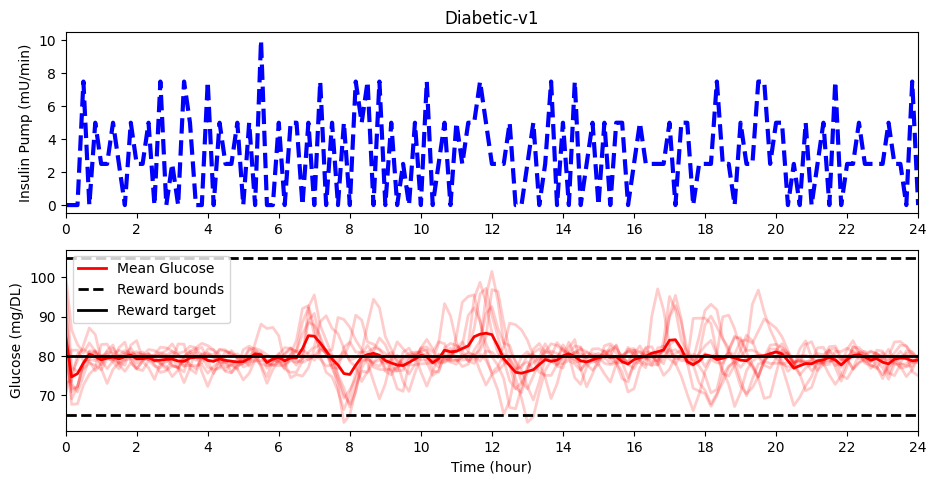

In [6]:
def plot_env(agent, n_episodes):
    env = gym.make(env_name)
    env.set_episode_length(10)
    glucose_list = []
    action_list = []
    rewards_list = []
    for e in range(n_episodes):
        state, _ = env.reset()
        for _ in range(env.episode_length-2):
            state = normalise(state)
            action = agent.get_action(state)
            # get_max(state)
            state, reward, done, _ = env.step(np.array([action*agent.action_multiplier]))
            rewards_list.append(reward)
            # if done:
            #     break
        glucose_list.append(env.G)
        action_list.append(env.u)
        

    # Plot the results
    plt.figure(1, figsize=(11,8))
    ticks = np.linspace(0,24,13)

    ax = plt.subplot(3,1,1)
    plt.plot(env.t, env.u, 'b--', linewidth=3)
    plt.ylabel('Insulin Pump (mU/min)')
    plt.xlim([0,24])
    plt.xticks(ticks)
    plt.title(env_name)

    ax = plt.subplot(3,1,2)
    for l in glucose_list:
        plt.plot(env.t, l, 'r-',linewidth=2, alpha=0.2)
    plt.plot(env.t, np.array(glucose_list).mean(axis=0),'r-',linewidth=2, label='Mean Glucose')
    plt.plot([0,24],[105,105],'k--',linewidth=2,label='Reward bounds')
    plt.plot([0,24],[80,80],'k-',linewidth=2,label='Reward target')
    plt.plot([0,24],[65,65],'k--',linewidth=2)
    plt.ylabel('Glucose (mg/DL)')
    plt.legend(loc='best')
    plt.xlim([0,24])
    plt.xticks(ticks)
    plt.xlabel('Time (hour)')
    plt.show()

env_name = "Diabetic-v1"
plot_env(agent_ce, 10)

In [ ]:
def plot_returns(returns, title="Average Return vs Epochs"):
    plt.figure(figsize=(10, 5))
    plt.plot(list(range(1, len(returns)+1)), returns, label='Average Return')
    plt.xlabel('Epochs')
    plt.ylabel('Average Return')
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.show()


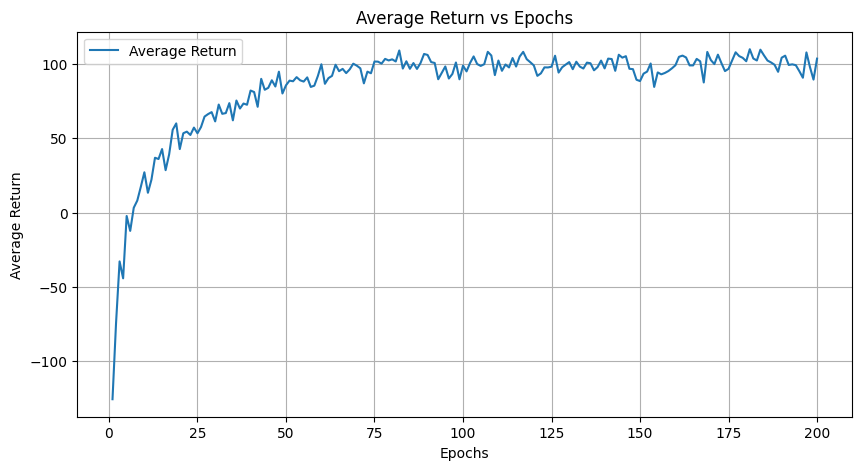

In [13]:
plot_returns(agent.epoch_wise_returns)

In [24]:
def get_avg_reward(agent, n_episodes):
    # env = gym.make(env_name)
    # env.set_episode_length(10)
    
    ret_list = []
    for e in range(n_episodes):
        state, _ = agent.env.reset()
        ret = 0
        # print(agent.value_net(torch.tensor(state, dtype=torch.float32)))
        for _ in range(agent.env.episode_length-2):
            state = normalise(state)
            action = agent.get_action(state)
            state, reward, done, _ = agent.env.step(np.array([action*agent.action_multiplier]))
            ret += reward
            # if done:
            #     break
        ret_list.append(ret)
    avg_ret = np.mean(ret_list)
    std_ret = np.std(ret_list)
    return avg_ret, std_ret

avg_ret, std_ret = get_avg_reward(agent, 100)
print(f"Average reward over 100 episodes: {avg_ret:.2f} ± {std_ret:.2f}")

Average reward over 100 episodes: 100.64 ± 20.61


In [64]:
avg_ret, std_ret = get_avg_reward(agent_ce, 100)
print(f"Average reward over 100 episodes: {avg_ret:.2f} ± {std_ret:.2f}")

Average reward over 100 episodes: 111.68 ± 4.11


In [71]:
def evaluate_sigma_reg(sigma, regularizer, beta):
    import dosing_rl_gym
    agent1 = Agent(sig=sigma, regularizer=regularizer, beta=beta, n_episodes=20, n_actions=5)
    agent1.train(n_epochs=200, verbose=False)
    avg_ret, std_ret = get_avg_reward(agent1, 100)
    return sigma, avg_ret, std_ret

In [72]:
sigma_vals = [1e-4, 1e-3, 0.01, 0.03, 0.1, 0.3, 1, 10]
results_sig_ce = Parallel(n_jobs=-1)(delayed(evaluate_sigma_reg)(x, cross_entropy_loss, 0.1) for x in sigma_vals)
results_sig_lb = Parallel(n_jobs=-1)(delayed(evaluate_sigma_reg)(x, log_barrier_loss, 0.001) for x in sigma_vals)
# for sigma, avg_ret, std_ret in results:
#     print(f"Average reward for sigma={sigma}: {avg_ret:.2f} ± {std_ret:.2f}")

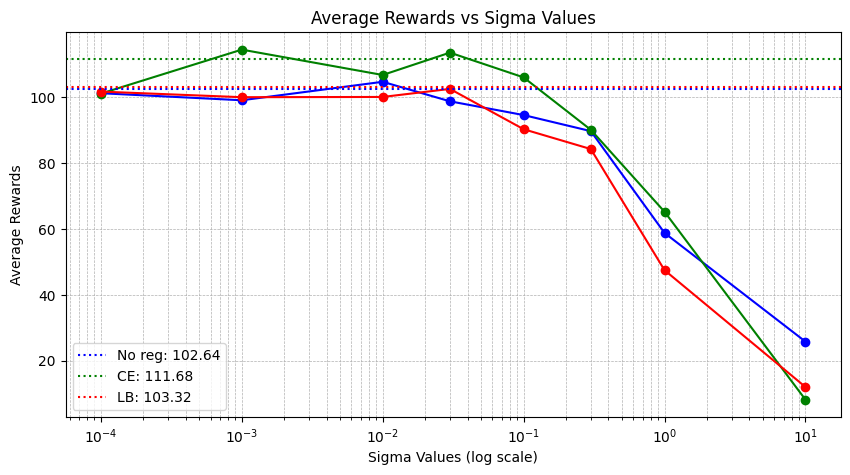

In [78]:
avg_rets_sig_unreg = [101.28, 99.14, 104.75, 98.82, 94.64, 89.75, 58.81, 25.77] 
avg_rets_sig_ce = [avg_ret for _, avg_ret, _ in results_sig_ce]
avg_rets_sig_lb = [avg_ret for _, avg_ret, _ in results_sig_lb]
avg_rets_sig_ce[2] = 106.82

ideal_ret_non_reg = 102.64
ideal_ret_ce = 111.68
ideal_ret_lb = 103.32
plt.figure(figsize=(10, 5))
plt.semilogx(sigma_vals, avg_rets_sig_unreg, marker='o', linestyle='-', color='b')
plt.semilogx(sigma_vals, avg_rets_sig_ce, marker='o', linestyle='-', color='g')
plt.semilogx(sigma_vals, avg_rets_sig_lb, marker='o', linestyle='-', color='r')
plt.axhline(y=ideal_ret_non_reg, color='b', linestyle=':', linewidth=1.5, label=f'No reg: {ideal_ret_non_reg:.2f}')
plt.axhline(y=ideal_ret_ce, color='g', linestyle=':', linewidth=1.5, label=f'CE: {ideal_ret_ce:.2f}')
plt.axhline(y=ideal_ret_lb, color='r', linestyle=':', linewidth=1.5, label=f'LB: {ideal_ret_lb:.2f}')
plt.xlabel("Sigma Values (log scale)")
plt.ylabel("Average Rewards")
plt.title("Average Rewards vs Sigma Values")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.legend()
plt.show()

In [76]:
def evaluate_eps_delta_reg(epsilon, delta, regularizer, beta):
    import dosing_rl_gym
    if epsilon < 1:
        z = np.sqrt(2 * np.log(1.25 / delta)) / epsilon
    else:
        c2 = np.sqrt(np.log(2/(np.sqrt(16*delta+1)-1)))
        z =(c2 + np.sqrt(c2*c2 + epsilon)) / (epsilon * np.sqrt(2))
    
    z = float(z)
    
    agent1 = Agent(beta=beta, regularizer=regularizer, sig=z, n_episodes=20)
    agent1.train(n_epochs=200, verbose=False)
    avg_ret, std_ret = get_avg_reward(agent1, 100)
    return z, avg_ret, std_ret

In [ ]:
epsilon_vals = [0.1, 0.2, 0.5, 1.0, 2, 5.0, 10.0, 20.0, 50, 100]
# z_vals = [evaluate_eps_delta(epsilon, delta) for epsilon in epsilon_vals]
results_eps_del5_ce = Parallel(n_jobs=-1)(delayed(evaluate_eps_delta_reg)(epsilon, 1e-5, cross_entropy_loss, 0.1) for epsilon in epsilon_vals)
results_eps_del1_ce = Parallel(n_jobs=-1)(delayed(evaluate_eps_delta_reg)(epsilon, 1e-1, cross_entropy_loss, 0.1) for epsilon in epsilon_vals)
results_eps_del5_lb = Parallel(n_jobs=-1)(delayed(evaluate_eps_delta_reg)(epsilon, 1e-5, log_barrier_loss, 0.001) for epsilon in epsilon_vals)
results_eps_del1_lb = Parallel(n_jobs=-1)(delayed(evaluate_eps_delta_reg)(epsilon, 1e-1, log_barrier_loss, 0.001) for epsilon in epsilon_vals)
for epsilon, (z, avg_ret, std_ret) in zip(epsilon_vals, results_eps_del):
#     print(f"Epsilon={epsilon}, delta={delta}, z={z:.4f} => Avg Reward: {avg_ret:.2f} ± {std_ret:.2f}")

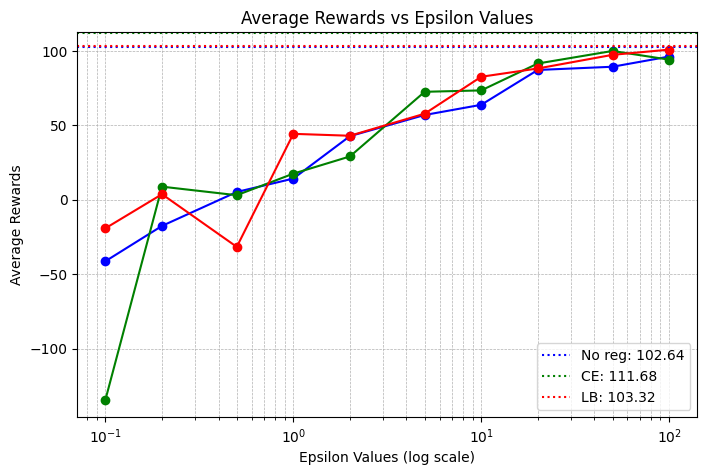

In [83]:
avg_rets_eps_del5_unreg = [res[1] for res in results_eps_del5_unreg]
avg_rets_eps_del5_ce = [res[1] for res in results_eps_del5_ce]
avg_rets_eps_del5_lb = [res[1] for res in results_eps_del5_lb]

plt.figure(figsize=(8, 5))
plt.semilogx(epsilon_vals, avg_rets_eps_del5_unreg, marker='o', linestyle='-', color='b')
plt.semilogx(epsilon_vals, avg_rets_eps_del5_ce, marker='o', linestyle='-', color='g')
plt.semilogx(epsilon_vals, avg_rets_eps_del5_lb, marker='o', linestyle='-', color='r')
plt.axhline(y=ideal_ret_non_reg, color='b', linestyle=':', linewidth=1.5, label=f'No reg: {ideal_ret_non_reg:.2f}')
plt.axhline(y=ideal_ret_ce, color='g', linestyle=':', linewidth=1.5, label=f'CE: {ideal_ret_ce:.2f}')
plt.axhline(y=ideal_ret_lb, color='r', linestyle=':', linewidth=1.5, label=f'LB: {ideal_ret_lb:.2f}')
plt.xlabel("Epsilon Values (log scale)")
plt.ylabel("Average Rewards")
plt.title("Average Rewards vs Epsilon Values")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.legend()
plt.show()

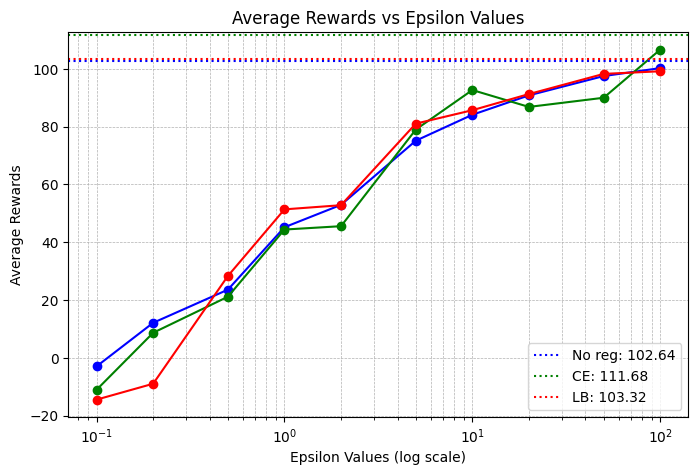

In [80]:
avg_rets_eps_del1_unreg = [res[1] for res in results_eps_del1_unreg]
avg_rets_eps_del1_ce = [res[1] for res in results_eps_del1_ce]
avg_rets_eps_del1_lb = [res[1] for res in results_eps_del1_lb]

plt.figure(figsize=(8, 5))
plt.semilogx(epsilon_vals, avg_rets_eps_del1_unreg, marker='o', linestyle='-', color='b')
plt.semilogx(epsilon_vals, avg_rets_eps_del1_ce, marker='o', linestyle='-', color='g')
plt.semilogx(epsilon_vals, avg_rets_eps_del1_lb, marker='o', linestyle='-', color='r')
plt.axhline(y=ideal_ret_non_reg, color='b', linestyle=':', linewidth=1.5, label=f'No reg: {ideal_ret_non_reg:.2f}')
plt.axhline(y=ideal_ret_ce, color='g', linestyle=':', linewidth=1.5, label=f'CE: {ideal_ret_ce:.2f}')
plt.axhline(y=ideal_ret_lb, color='r', linestyle=':', linewidth=1.5, label=f'LB: {ideal_ret_lb:.2f}')
plt.xlabel("Epsilon Values (log scale)")
plt.ylabel("Average Rewards")
plt.title("Average Rewards vs Epsilon Values")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.legend()
plt.show()

In [ ]:
def evaluate_heads(heads):
    import dosing_rl_gym
    
    agent1 = Agent(sig=0, beta=0.1, n_episodes=20, n_actions=heads)
    agent1.train(n_epochs=200, verbose=False)
    avg_ret, std_ret = get_avg_reward(agent1, 100)
    return heads, avg_ret, std_ret

In [ ]:
n_heads = [2, 3, 4, 5, 6, 7]
results = Parallel(n_jobs=-1)(delayed(evaluate_heads)(x) for x in n_heads)
for heads, avg_ret, std_ret in results:
    print(f"Average reward for heads={heads}: {avg_ret:.2f} ± {std_ret:.2f}")

Average reward for heads=2: 103.84 ± 8.86
Average reward for heads=3: 109.36 ± 4.35
Average reward for heads=4: 107.67 ± 5.10
Average reward for heads=5: 107.48 ± 9.54
Average reward for heads=6: 113.33 ± 8.83
Average reward for heads=7: 112.67 ± 4.80


In [66]:
def evaluate_beta(beta, regularizer):
    import dosing_rl_gym
    agent1 = Agent(beta=beta, sig=0, n_episodes=20, n_actions=5, regularizer=regularizer)
    agent1.train(n_epochs=200, verbose=False)
    avg_ret, std_ret = get_avg_reward(agent1, 100)
    return beta, avg_ret, std_ret

In [ ]:
beta_vals = [0, 1e-3, 1e-2, 0.1, 1, 10]
results_beta = Parallel(n_jobs=-1)(delayed(evaluate_beta)(x, cross_entropy_loss) for x in beta_vals)
for beta, avg_ret, std_ret in results_beta:
    print(f"Average reward for beta={beta}: {avg_ret:.2f} ± {std_ret:.2f}")

Average reward for beta=0: 104.39 ± 17.56
Average reward for beta=0.001: 100.93 ± 19.17
Average reward for beta=0.01: 103.60 ± 18.71
Average reward for beta=0.1: 114.53 ± 5.18
Average reward for beta=1: 53.40 ± 19.29
Average reward for beta=10: -113.47 ± 24.29


In [67]:
beta_vals = [0, 1e-3, 1e-2, 0.05, 0.1, 0.2, 1, 10]
results_beta = Parallel(n_jobs=-1)(delayed(evaluate_beta)(x, log_barrier_loss) for x in beta_vals)
print("Log barrier")
for beta, avg_ret, std_ret in results_beta:
    print(f"Average reward for beta={beta}: {avg_ret:.2f} ± {std_ret:.2f}")

Log barrier
Average reward for beta=0: 99.65 ± 20.94
Average reward for beta=0.001: 101.58 ± 21.24
Average reward for beta=0.01: 25.16 ± 53.58
Average reward for beta=0.05: 29.04 ± 49.14
Average reward for beta=0.1: 25.96 ± 60.53
Average reward for beta=0.2: 15.40 ± 56.49
Average reward for beta=1: -140.48 ± 1.61
Average reward for beta=10: -137.13 ± 5.82


In [69]:
beta_vals = [1e-4, 2e-4, 5e-4, 1e-3, 2e-3, 5e-3]
results_beta = Parallel(n_jobs=-1)(delayed(evaluate_beta)(x, log_barrier_loss) for x in beta_vals)
print("Log barrier")
for beta, avg_ret, std_ret in results_beta:
    print(f"Average reward for beta={beta}: {avg_ret:.2f} ± {std_ret:.2f}")

Log barrier
Average reward for beta=0.0001: 102.47 ± 21.37
Average reward for beta=0.0002: 100.70 ± 20.61
Average reward for beta=0.0005: 100.71 ± 21.23
Average reward for beta=0.001: 105.02 ± 18.09
Average reward for beta=0.002: 94.10 ± 16.25
Average reward for beta=0.005: 103.13 ± 20.32


In [70]:
beta_vals = [1e-7, 1e-6, 1e-5]
results_beta = Parallel(n_jobs=-1)(delayed(evaluate_beta)(x, log_barrier_loss) for x in beta_vals)
print("Log barrier")
for beta, avg_ret, std_ret in results_beta:
    print(f"Average reward for beta={beta}: {avg_ret:.2f} ± {std_ret:.2f}")

Log barrier
Average reward for beta=1e-07: 100.05 ± 20.20
Average reward for beta=1e-06: 104.57 ± 17.00
Average reward for beta=1e-05: 103.80 ± 16.86


In [16]:
def evaluate_sigma(sigma):
    # import gym
    import dosing_rl_gym
    # gym.register(
    #     id='Diabetic-v1',
    #     entry_point='dosing_rl_gym'
    # )
    agent1 = Agent(sig=sigma)
    agent1.train(n_epochs=200, verbose=False)
    avg_ret, std_ret = get_avg_reward(agent1, 100)
    return sigma, avg_ret, std_ret

In [17]:
sigma_vals = [1e-4, 1e-3, 0.01, 0.1, 1, 10]

results = Parallel(n_jobs=-1)(delayed(evaluate_sigma)(x) for x in sigma_vals)

for sigma, avg_ret, std_ret in results:
    print(f"Average reward for sigma={sigma}: {avg_ret:.2f} ± {std_ret:.2f}")


Average reward for sigma=0.0001: 101.28 ± 23.26
Average reward for sigma=0.001: 99.14 ± 18.96
Average reward for sigma=0.01: 104.75 ± 17.16
Average reward for sigma=0.1: 94.64 ± 17.00
Average reward for sigma=1: 58.81 ± 23.77
Average reward for sigma=10: 25.77 ± 32.31


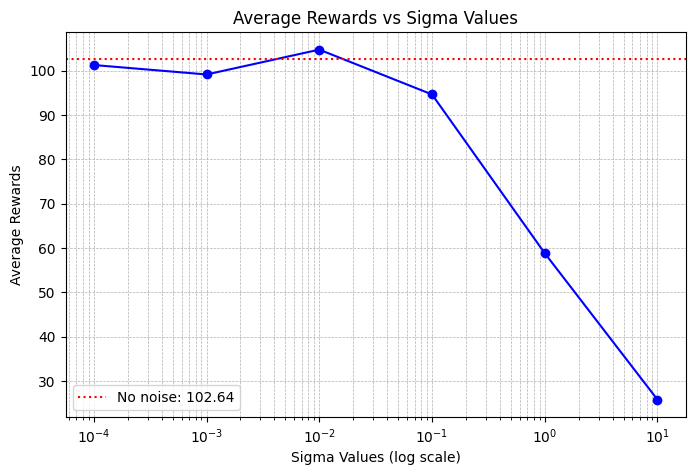

In [27]:
avg_rets = [res[1] for res in results]
ideal_ret_non_reg = 102.64
plt.figure(figsize=(8, 5))
plt.semilogx(sigma_vals, avg_rets, marker='o', linestyle='-', color='b')
plt.axhline(y=ideal_ret_non_reg, color='r', linestyle=':', linewidth=1.5, label=f'No noise: {ideal_ret_non_reg:.2f}')
plt.xlabel("Sigma Values (log scale)")
plt.ylabel("Average Rewards")
plt.title("Average Rewards vs Sigma Values")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.legend()
plt.show()

In [ ]:
sigma_vals2 = [0.04, 0.07, 0.1, 0.3, 0.6]

results2 = Parallel(n_jobs=-1)(delayed(evaluate_sigma)(x) for x in sigma_vals2)

for sigma, avg_ret, std_ret in results2:
    print(f"Average reward for sigma={sigma}: {avg_ret:.2f} ± {std_ret:.2f}")

Average reward for sigma=0.04: 98.82 ± 19.69
Average reward for sigma=0.07: 98.27 ± 19.88
Average reward for sigma=0.1: 100.89 ± 17.30
Average reward for sigma=0.3: 89.75 ± 17.01
Average reward for sigma=0.6: 62.69 ± 26.23


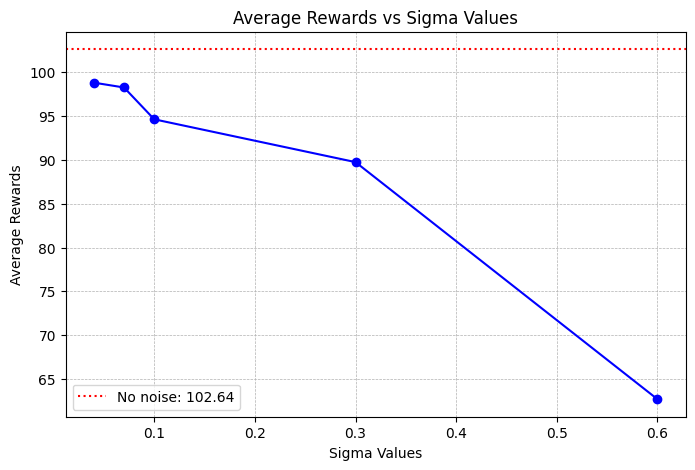

In [33]:
avg_rets2 = [res[1] for res in results2]
avg_rets2[2] = 94.64

plt.figure(figsize=(8, 5))
plt.plot(sigma_vals2, avg_rets2, marker='o', linestyle='-', color='b')
plt.axhline(y=ideal_ret_non_reg, color='r', linestyle=':', linewidth=1.5, label=f'No noise: {ideal_ret_non_reg:.2f}')
plt.xlabel("Sigma Values")
plt.ylabel("Average Rewards")
plt.title("Average Rewards vs Sigma Values")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.legend()
plt.show()

In [30]:
def evaluate_clipping(clipping):
    import dosing_rl_gym
    agent1 = Agent(sig=0.1, beta=0.0, n_episodes=20, n_actions=5, C=clipping)
    agent1.train(n_epochs=200, verbose=False)
    avg_ret, std_ret = get_avg_reward(agent1, 100)
    return clipping, avg_ret, std_ret

In [ ]:
percentiles = [1, 10, 20, 30, 40, 50, 60, 70, 80, 90]
norms = agent.norms
clipping_vals = [float(np.percentile(norms, p)) for p in percentiles]
clipping_vals
results_clipping = Parallel(n_jobs=-1)(delayed(evaluate_clipping)(x) for x in clipping_vals)

for clip, avg_ret, std_ret in results_clipping:
    print(f"Average reward for clipping={clip:.3f}: {avg_ret:.2f} ± {std_ret:.2f}")

Average reward for clipping=6.934: 98.89 ± 20.06
Average reward for clipping=33.141: 103.22 ± 17.07
Average reward for clipping=95.894: 99.42 ± 21.66
Average reward for clipping=162.409: 101.24 ± 18.78
Average reward for clipping=253.968: 102.17 ± 18.83
Average reward for clipping=428.257: 94.74 ± 20.41


In [54]:
percentiles = [1, 10, 30, 50, 60, 70, 80, 90, 95, 99, 100]
norms = agent.norms
clipping_vals = [float(np.percentile(norms, p)) for p in percentiles]
clipping_vals
results_clipping = Parallel(n_jobs=-1)(delayed(evaluate_clipping)(x) for x in clipping_vals)

for clip, avg_ret, std_ret in results_clipping:
    print(f"Average reward for clipping={clip:.3f}: {avg_ret:.2f} ± {std_ret:.2f}")

Average reward for clipping=6.934: 94.93 ± 16.15
Average reward for clipping=33.141: 99.05 ± 24.51
Average reward for clipping=95.894: 100.07 ± 20.24
Average reward for clipping=162.409: 96.58 ± 18.59
Average reward for clipping=203.700: 96.78 ± 14.05
Average reward for clipping=253.968: 97.69 ± 15.38
Average reward for clipping=323.250: 96.96 ± 17.52
Average reward for clipping=428.257: 89.83 ± 23.26
Average reward for clipping=530.831: 97.77 ± 13.19
Average reward for clipping=722.216: 95.21 ± 19.79
Average reward for clipping=1480.590: 76.48 ± 16.17


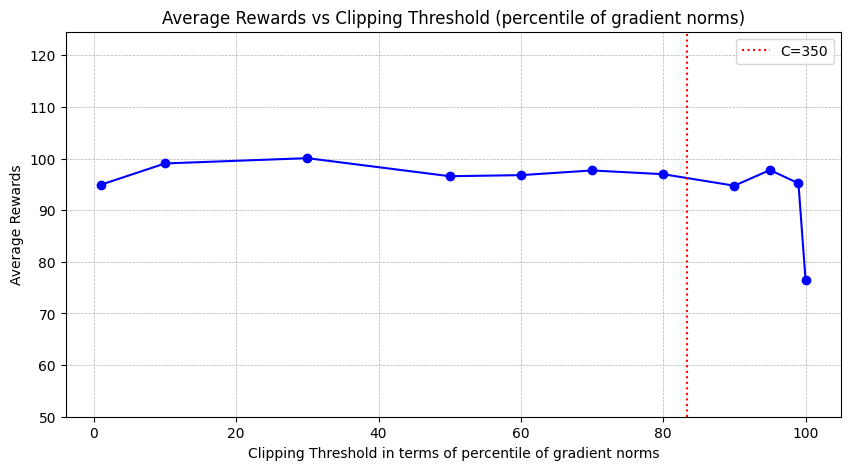

In [56]:
avg_rets_clipping = [res[1] for res in results_clipping]
std_rets_clipping = [res[2] for res in results_clipping]
avg_rets_clipping[7] = 94.74
norms.sort()
for i in range(len(norms)):
    if norms[i] > 350:
        my_norm_percentile = i / len(norms) * 100
        break


plt.figure(figsize=(10, 5))
plt.plot(percentiles, avg_rets_clipping, marker='o', linestyle='-', color='b')
plt.axvline(x=my_norm_percentile, color='r', linestyle=':', linewidth=1.5, label=f'C={350}')

# Customize labels and title
plt.xlabel("Clipping Threshold in terms of percentile of gradient norms")
plt.ylabel("Average Rewards")
plt.title("Average Rewards vs Clipping Threshold (percentile of gradient norms)")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

# Set custom y-limits (optional; tweak as needed)
y_min = 50
y_max = max(avg + std for avg, std in zip(avg_rets_clipping, std_rets_clipping)) + 1
plt.ylim(y_min, y_max)

plt.legend()
plt.show()


In [57]:
def evaluate_eps_delta_unreg(epsilon, delta):
    import dosing_rl_gym
    if epsilon < 1:
        z = np.sqrt(2 * np.log(1.25 / delta)) / epsilon
    else:
        c2 = np.sqrt(np.log(2/(np.sqrt(16*delta+1)-1)))
        z =(c2 + np.sqrt(c2*c2 + epsilon)) / (epsilon * np.sqrt(2))
    
    z = float(z)
    
    agent1 = Agent(beta=0.0, sig=z, n_episodes=20)
    agent1.train(n_epochs=200, verbose=False)
    avg_ret, std_ret = get_avg_reward(agent1, 100)
    return z, avg_ret, std_ret

In [ ]:
epsilon_vals = [0.1, 0.2, 0.5, 1.0, 2, 5.0, 10.0, 20.0, 50, 100]

results_eps_del5_unreg = Parallel(n_jobs=-1)(delayed(evaluate_eps_delta_unreg)(epsilon, 1e-5) for epsilon in epsilon_vals)
results_eps_del3_unreg = Parallel(n_jobs=-1)(delayed(evaluate_eps_delta_unreg)(epsilon, 1e-3) for epsilon in epsilon_vals)
results_eps_del1_unreg = Parallel(n_jobs=-1)(delayed(evaluate_eps_delta_unreg)(epsilon, 1e-1) for epsilon in epsilon_vals)

for epsilon, (z, avg_ret, std_ret) in zip(epsilon_vals, results_eps_del5_unreg):
    print(f"Epsilon={epsilon}, delta={1e-5}, z={z:.4f} => Avg Reward: {avg_ret:.2f} ± {std_ret:.2f}")

Epsilon=0.1, delta=1e-05, z=48.4481 => Avg Reward: -41.31 ± 23.99
Epsilon=0.2, delta=1e-05, z=24.2240 => Avg Reward: -17.61 ± 22.69
Epsilon=0.5, delta=1e-05, z=9.6896 => Avg Reward: 5.18 ± 24.81
Epsilon=1.0, delta=1e-05, z=4.6089 => Avg Reward: 14.18 ± 25.31
Epsilon=2, delta=1e-05, z=2.3563 => Avg Reward: 42.67 ± 29.69
Epsilon=5.0, delta=1e-05, z=1.0001 => Avg Reward: 56.88 ± 26.24
Epsilon=10.0, delta=1e-05, z=0.5422 => Avg Reward: 63.73 ± 31.58
Epsilon=20.0, delta=1e-05, z=0.3066 => Avg Reward: 87.12 ± 17.88
Epsilon=50, delta=1e-05, z=0.1547 => Avg Reward: 89.29 ± 21.95
Epsilon=100, delta=1e-05, z=0.0967 => Avg Reward: 96.12 ± 18.78


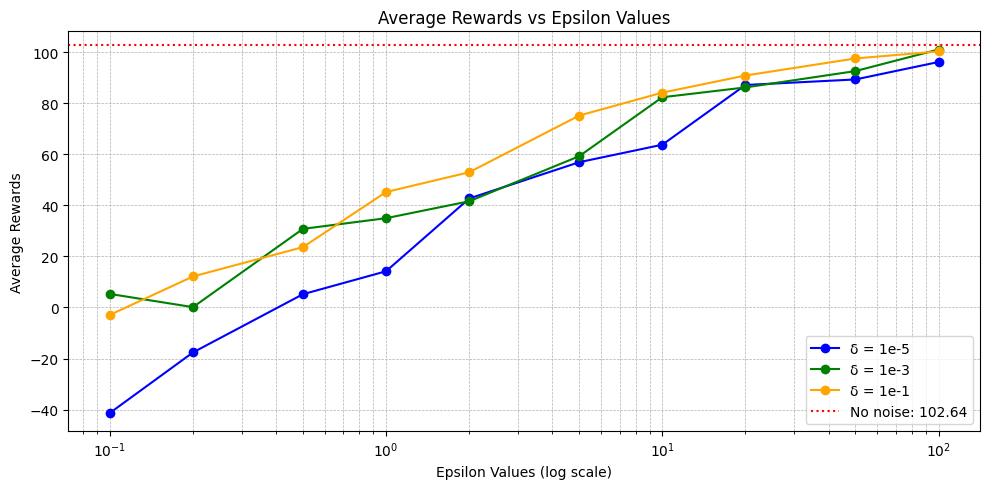

In [61]:
avg_rets_eps_del5_unreg = [res[1] for res in results_eps_del5_unreg]
avg_rets_eps_del3_unreg = [res[1] for res in results_eps_del3_unreg]
avg_rets_eps_del1_unreg = [res[1] for res in results_eps_del1_unreg]

plt.figure(figsize=(10, 5))
plt.semilogx(epsilon_vals, avg_rets_eps_del5_unreg, marker='o', linestyle='-', color='b', label='δ = 1e-5')
plt.semilogx(epsilon_vals, avg_rets_eps_del3_unreg, marker='o', linestyle='-', color='g', label='δ = 1e-3')
plt.semilogx(epsilon_vals, avg_rets_eps_del1_unreg, marker='o', linestyle='-', color='orange', label='δ = 1e-1')
plt.axhline(y=ideal_ret_non_reg, color='r', linestyle=':', linewidth=1.5, label=f'No noise: {ideal_ret_non_reg:.2f}')
plt.xlabel("Epsilon Values (log scale)")
plt.ylabel("Average Rewards")
plt.title("Average Rewards vs Epsilon Values")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.legend()
plt.show()